In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

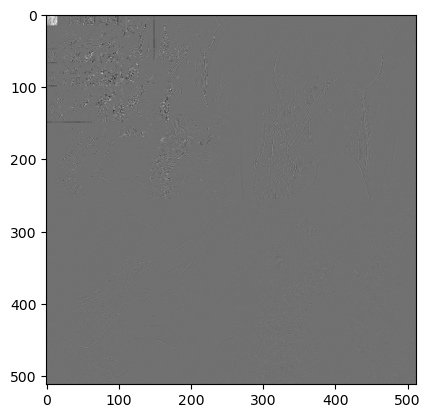

In [2]:
# load image
img = np.load('l5_decomp_quant.npy')
plt.imshow(img, cmap='gray')

In [3]:
# create a EZW tree class
class EZWTree:
    def __init__(self, value, level, quadrant, coordinates, children, parent):
        self.value = value
        self.level = level
        self.children = children if children is not None else []
        self.quadrant = quadrant
        self.coordinates = coordinates
        self.ezwcode = None
        self.parent = parent
    
def build_tree(image, level=0, coordinates=(1,0), quadrant=None, parent=None):
    i, j = coordinates
    # Base case: if the coordinates are out of the image boundary, return None
    if i >= image.shape[0] or j >= image.shape[1]:
        return None

    # create the list of children coordinates
    child_coordinates = [(2*i, 2*j+1), (2*i, 2*j), (2*i + 1, 2*j), (2*i + 1, 2*j + 1)]

    node = EZWTree(image[i, j], level, quadrant, coordinates, children=[], parent=parent)

    # recursively create the children
    for coord in child_coordinates:
        ci, cj = coord
        # Check if the child coordinates are within the image boundary
        if ci < image.shape[0] and cj < image.shape[1]:
            child = build_tree(image, level+1, coord, quadrant, parent=node)
            node.children.append(child)

    return node

In [90]:
# enumerate the img[0,16:0,16]
root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = build_tree(img, 1, (i,j+16), 1, None)
        child_3 = build_tree(img, 1, (i+16,j), 3, None)
        child_4 = build_tree(img, 1, (i+16,j+16), 4, None)
        root_nodes[i][j] = EZWTree(img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None)
        child_1.parent = root_nodes[i][j]
        child_3.parent = root_nodes[i][j]
        child_4.parent = root_nodes[i][j]

## Set ezw code

- P positive
- N negative
- Z isolated zero
- T zero tree root

In [91]:
def bfs_traverse(root, threshold):
    # use BFS to traverse the tree
    queue = [root]
    dominant_pass_result = []
    subdominant_pass_result = []
    while queue:
        node = queue.pop(0)
        # check if the node is a leaf node
            # check if the node is a zero node
        if np.abs(node.value) > threshold:
            if node.value > 0:
                node.ezwcode = 'P'
                dominant_pass_result.append(node.ezwcode)
                if node.value > 3/2 * threshold:
                    subdominant_pass_result.append(1)
                else:
                    subdominant_pass_result.append(0)
            else:
                node.ezwcode = 'N'
                dominant_pass_result.append(node.ezwcode)
                if node.value < -3/2 * threshold:
                    subdominant_pass_result.append(1)
                else:
                    subdominant_pass_result.append(0)
            # set node value to 0        
            node.value = 0
        else:
            # does code descend from ZTR?
            if node.level > 0 and node.parent.ezwcode == 'T':
                continue
            else:
            # does code have significant descendant?
                if node.children:
                    if any([child.value > threshold or child.value < -threshold for child in node.children]):
                        node.ezwcode = 'Z' #Isolated zero
                        dominant_pass_result.append(node.ezwcode)
                    else:
                        node.ezwcode = 'T' #ZTR
                        dominant_pass_result.append(node.ezwcode)
                else:
                    node.ezwcode = 'T' #ZTR
                    dominant_pass_result.append(node.ezwcode)
        # print coordinates, value, ezwcode
        # print(node.coordinates, node.value, node.ezwcode)
        # add the children to the queue
        if node.children:
            queue.extend(node.children)
    return dominant_pass_result, subdominant_pass_result


In [94]:
def enc_dp_sp(root_nodes_list, threshold0, pass_num):
    dpr_list = []
    spr_list = []
    for i in range(pass_num):
        dpr_array = [[None for _ in range(16)] for _ in range(16)]
        dpr_list.append(dpr_array)
        spr_array = [[None for _ in range(16)] for _ in range(16)]
        spr_list.append(spr_array)

    for passn in range(pass_num):
        for i in range(0, 16):
            for j in range(0, 16):
                dpr, spr = bfs_traverse(root_nodes_list[i][j], threshold0)
                dpr_list[passn][i][j] = dpr
                spr_list[passn][i][j] = spr
        threshold0 /= 2
    return dpr_list, spr_list

In [95]:
dpr_list, spr_list = enc_dp_sp(root_nodes, 128, 8)

## reconstruct image

In [96]:
# enumerate the img[0,16:0,16]
recon_img = np.zeros((512,512)).astype('float64')
recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = build_tree(recon_img, 1, (i,j+16), 1, None)
        child_3 = build_tree(recon_img, 1, (i+16,j), 3, None)
        child_4 = build_tree(recon_img, 1, (i+16,j+16), 4, None)
        recon_root_nodes[i][j] = EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None)
        child_1.parent = recon_root_nodes[i][j]
        child_3.parent = recon_root_nodes[i][j]
        child_4.parent = recon_root_nodes[i][j]

In [70]:
def decode_tree(root, dominant_pass, subdominant_pass, threshold):
    print('------')
    print('threshold:', threshold )
    print(root.coordinates)
    print(dominant_pass)
    print(subdominant_pass)
    queue = [root]
    idx = 0
    sub_idx = 0
    
    while queue:
        node = queue.pop(0)
        ezwcode = dominant_pass[idx]
        i, j = node.coordinates
        if ezwcode == 'P' or ezwcode == 'N':
            node.value = threshold + threshold/4 if ezwcode == 'P' else -threshold - threshold/4
            if subdominant_pass[sub_idx] == 1:
                if ezwcode == 'P':
                    node.value = node.value + threshold / 2
                else:
                    node.value = node.value - threshold / 2
                sub_idx += 1
            recon_img[i, j] = node.value
            idx += 1
            print(idx, node.coordinates, node.value)
        elif ezwcode == 'Z':
            idx += 1
            print('Z')
            pass
        elif ezwcode == 'T': # ZTR
            idx += 1
            print('T')
            continue
        if node.children:
            queue.extend(node.children)
    return


In [ ]:
# for i in range(0, 16):
#     for j in range(0, 16):
#         decode_tree(recon_root_nodes[i][j], dpr_array[i][j], spr_array[i][j], threshold)

In [97]:
def dec_dp_sp(dpr_list,spr_list, threshold0):
    pass_num = len(dpr_list)
    for passn in range(pass_num):
        for i in range(0, 16):
            for j in range(0, 16):
                decode_tree(recon_root_nodes[i][j], dpr_list[passn][i][j], spr_list[passn][i][j], threshold0)
        threshold0 /= 2

In [98]:
dec_dp_sp(dpr_list,spr_list, 128)

------
threshold: 128
(0, 0)
['P', 'T', 'T', 'T']
[0]
1 (0, 0) 160.0
T
T
T
------
threshold: 128
(0, 1)
['T']
[]
T
------
threshold: 128
(0, 2)
['T']
[]
T
------
threshold: 128
(0, 3)
['P', 'T', 'T', 'T']
[0]
1 (0, 3) 160.0
T
T
T
------
threshold: 128
(0, 4)
['P', 'T', 'T', 'T']
[0]
1 (0, 4) 160.0
T
T
T
------
threshold: 128
(0, 5)
['P', 'T', 'T', 'T']
[0]
1 (0, 5) 160.0
T
T
T
------
threshold: 128
(0, 6)
['P', 'T', 'T', 'T']
[0]
1 (0, 6) 160.0
T
T
T
------
threshold: 128
(0, 7)
['P', 'T', 'T', 'T']
[0]
1 (0, 7) 160.0
T
T
T
------
threshold: 128
(0, 8)
['P', 'T', 'T', 'T']
[0]
1 (0, 8) 160.0
T
T
T
------
threshold: 128
(0, 9)
['T']
[]
T
------
threshold: 128
(0, 10)
['P', 'T', 'T', 'T']
[0]
1 (0, 10) 160.0
T
T
T
------
threshold: 128
(0, 11)
['P', 'T', 'T', 'T']
[0]
1 (0, 11) 160.0
T
T
T
------
threshold: 128
(0, 12)
['P', 'T', 'T', 'T']
[0]
1 (0, 12) 160.0
T
T
T
------
threshold: 128
(0, 13)
['P', 'T', 'T', 'T']
[0]
1 (0, 13) 160.0
T
T
T
------
threshold: 128
(0, 14)
['T']
[]
T
------

In [99]:
bin_img = np.zeros((512,512))
bin_img[img != 0] = 1
check_filled = np.zeros((512,512))
check_filled[recon_img != 0] = 1

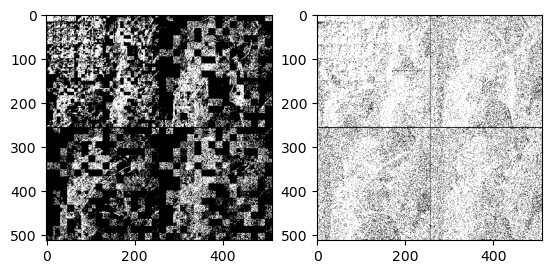

In [100]:
# plot check_filled and bin_img
plt.figure()
plt.subplot(1,2,1)
plt.imshow(check_filled, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(bin_img,  cmap='gray')

In [101]:
recon_img[0:16,0:16] = img[0:16,0:16]

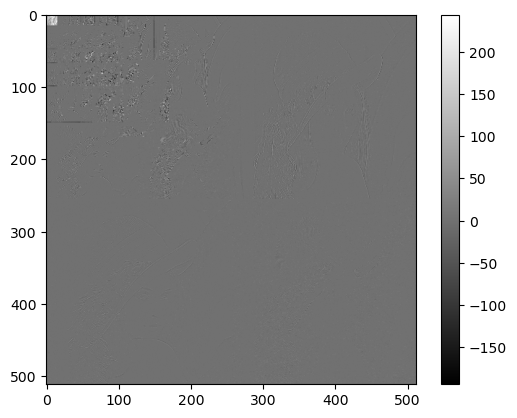

In [102]:
plt.imshow(img, cmap='gray')
plt.colorbar()

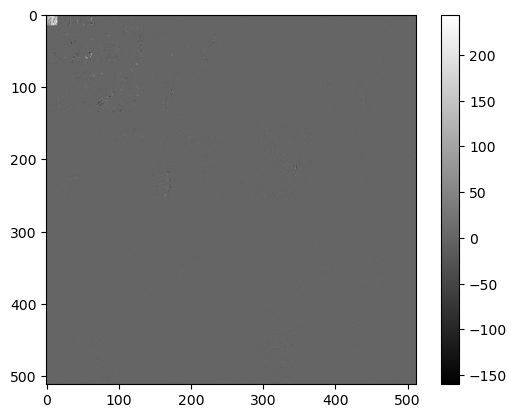

In [103]:
plt.imshow(recon_img, cmap='gray')
plt.colorbar()

In [104]:
# calculate psnr between img and recon_img
def psnr(img, recon_img):
    mse = np.mean((img - recon_img)**2)
    return 10 * np.log10(255**2/mse), mse
psnr(img, recon_img)

(31.05307140070654, 51.02384948730469)

In [105]:
# save reconstructed image to npy
np.save('recon_img_ezw.npy', recon_img)